**Comente o ignore estas lineas si no va a usarlas o modifique las rutas**

In [ ]:
# from google.colab import drive

# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importaciones y Configuración inicial

### 0. Entorno y Configuración Inicial

In [5]:
# Configuración para autoreload en notebooks
%load_ext autoreload
%autoreload 2

# Ignorar warnings para mantener la salida limpia
import warnings
warnings.filterwarnings("ignore")

# Bibliotecas estándar
import os
import sys
from functools import partial
from typing import Optional, List, Tuple, Literal # Para type hinting

# Bibliotecas de terceros
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import (
    DataLoader,
    Dataset,
    Subset,
    TensorDataset
)
from torch.optim import Adam
import tqdm


### 1. Importación de Módulos Locales

In [ ]:
from configuration_notebook_cifar10 import *

paths_to_add = ["diffusion", "utils", "models", "metrics", "samplers", "diffusion_utilities"]
print("Añadiendo rutas locales a sys.path si es necesario:")
for path_name in paths_to_add:
    abs_path = os.path.abspath(path_name)
    if abs_path not in sys.path:
        sys.path.insert(0, abs_path)
        print(f"  - Añadido: {abs_path}")
    else:
        print(f"  - Ya existe: {abs_path}")

# SDEs y Schedules
from sde import VESDE, VPSDE, SubVPSDE
from schedules import LinearSchedule, CosineSchedule

# Modelo
from score_net import ScoreNet

# Samplers (Integradores Numéricos)
from euler_maruyama import *
from predictor_corrector import *
from probability_flow_ode import *
from exponential_integrator import *

# Métricas
from fid_for_cifar10 import *
from inception_score import get_inception_score_for_generated_images
from metrics.bpd import calculate_bpd, compute_nll_scipy

# Utilidades (e.g., para visualización)
from diffusion_utilities import (
    plot_image_grid,
    plot_image_evolution,
    plot_image_evolution_pc,
    animation_images,
    plot_image_evolution_color
)
print("\nMódulos locales importados correctamente.")


Añadiendo rutas locales a sys.path si es necesario:
  - Ya existe: /content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v3/diffusion
  - Ya existe: /content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v3/utils
  - Ya existe: /content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v3/models
  - Ya existe: /content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v3/metrics
  - Ya existe: /content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v3/samplers
  - Ya existe: /content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v3/diffusion_utilities

Módulos locales importados correctamente.


### 2. Configuración del Hardware

In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print(f"GPU disponible. Usando: {torch.cuda.get_device_name(0)}")
else:
    DEVICE = torch.device('cpu')
    print("GPU no encontrada. Usando CPU.")

# Configuración de workers para DataLoader
N_THREADS = torch.get_num_threads() # Número de threads que PyTorch puede usar
NUM_WORKERS = min(4, os.cpu_count() // 2 if os.cpu_count() else 1) # Heurística, ajustar si es necesario
print(f'PyTorch puede usar hasta {N_THREADS} threads.')
print(f'Usando {NUM_WORKERS} workers para DataLoader.')


GPU disponible. Usando: Tesla T4
PyTorch puede usar hasta 1 threads.
Usando 1 workers para DataLoader.


### 3. Selección del Modelo y Parámetros SDE/Schedule ◀ ⚡

In [ ]:
# --- Selección del Modelo ---
# Elige UNO de los siguientes tipos.
# MODEL_TYPE = 'VE'
MODEL_TYPE = 'VP_Linear'
# MODEL_TYPE = 'VP_Cosine'
# MODEL_TYPE = 'SubVP_Linear'
# MODEL_TYPE = 'SubVP_Cosine'
print(f"\nTipo de Modelo/SDE seleccionado: {MODEL_TYPE}")


Tipo de Modelo/SDE seleccionado: VP_Linear


Número de Imagenes


In [ ]:
N_IMAGES = 6

In [ ]:
# --- Parámetros Generales SDE/Schedule ---
SIGMA_MIN = 0.01      # Valor mínimo de sigma (ruido) - Usado por VE, SubVP
SIGMA_MAX = 50.0      # Valor máximo de sigma (ruido) - Usado por VE, SubVP
SIGMA = 25.0          # Parámetro sigma específico (e.g., para score matching) - Usado por VE
BETA_MIN = 0.1        # Valor mínimo de beta (varianza del ruido) - Usado por VP, SubVP
BETA_MAX = 20.0       # Valor máximo de beta (varianza del ruido) - Usado por VP, SubVP
T_END = 1.0           # Tiempo final de la SDE / Schedule
T = 1
t_final = 1.0e-5
S = 0.008             # Parámetro 's' para CosineSchedule (controla la curvatura)
SCHEDULE_S = 0.008

### 5. Configuración del Conjunto de Datos y Entrenamiento

In [ ]:
# --- Parámetros del Dataset ---
IMG_SIZE = 32         # Tamaño de las imágenes (alto y ancho)
IMG_CHANNELS = 3      # Número de canales (3 para RGB)
DATASET_NAME = 'CIFAR10'

# --- Parámetros de Entrenamiento ---
BATCH_SIZE = 32       # Tamaño del lote para entrenamiento
LEARNING_RATE = 1e-4  # Tasa de aprendizaje para Adam (ajustar según sea necesario)
N_EPOCHS = 100        # Número total de épocas de entrenamiento (ejemplo)
EPS_LOSS = 1e-5       # Epsilon para muestrear t ~ U(eps, T) durante el entrenamiento

# --- Checkpoints ---
CHECKPOINT_DIR = './checkpoints' # Directorio para guardar/cargar modelos
CHECKPOINT_FREQ = 10           # Frecuencia (en épocas) para guardar checkpoints
# Crear directorio si no existe
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

### 6. Configuración de Generación y Evaluación

In [ ]:
# --- Parámetros de Generación (Sampling) ---
N_IMAGES_TO_GENERATE = 64 # Número de imágenes a generar para visualización/evaluación
SAMPLER_N_STEPS = 500     # Número de pasos para los solvers SDE/ODE (Euler, PC, etc.)
GEN_BATCH_SIZE = 64       # Tamaño del lote para la generación de imágenes

# Selecciona el sampler a usar para generar imágenes (y posiblemente para FID/IS si no se especifica otro)
# Opciones: euler_maruyama_integrator, pc_integrator, ode_sampler, exponential_integrator
SELECTED_SAMPLER = euler_maruyama_integrator
print(f"Sampler seleccionado para generación: {SELECTED_SAMPLER.__name__}")

# --- Parámetros de Evaluación FID (Frechet Inception Distance) ---
CALCULATE_FID = True       # Poner a False para saltar el cálculo de FID
N_FID_SAMPLES = 100      # Número de imágenes generadas para calcular FID (50k es estándar, 10k para pruebas rápidas)
FID_BATCH_SIZE = 128       # Batch size para pasar imágenes por la red Inception (ajustar según VRAM)
FID_DIMS = 2048            # Dimensiones de las activaciones Inception (2048 es estándar)
GEN_BATCH_SIZE_FID = 32
BINARIZE_FID_IMAGES = False # Binarizar imágenes antes de FID (True para MNIST, False para CIFAR-10/color)

# Se puede usar un sampler diferente o con distintos pasos para FID si es necesario
SAMPLER_FOR_FID = euler_maruyama_integrator
SAMPLER_STEPS_FOR_FID = SAMPLER_N_STEPS

# --- Parámetros de Evaluación IS (Inception Score) ---
CALCULATE_IS = True        # Poner a False para saltar el cálculo de IS
IS_SPLITS = 10             # Número de splits para calcular IS (estándar)

# --- Parámetros de Evaluación BPD (Bits Per Dimension) ---
CALCULATE_BPD = True       # Poner a False para saltar el cálculo de BPD/NLL
BPD_BATCH_SIZE = 64        # Batch size para calcular BPD

Sampler seleccionado para generación: euler_maruyama_integrator


In [ ]:
# --- Instanciar SDE según la configuración ---
if MODEL_TYPE == 'VE':
  sde_instance, score_model = sde_schedule_and_model(MODEL_TYPE, SIGMA_MIN, SIGMA_MAX, SIGMA, BETA_MIN, BETA_MAX, T_END, SCHEDULE_S, DEVICE)
else:
  sde_instance, schedule, score_model = sde_schedule_and_model(MODEL_TYPE, SIGMA_MIN, SIGMA_MAX, SIGMA, BETA_MIN, BETA_MAX, T_END, SCHEDULE_S, DEVICE)

Inicializado VPSDE con Schedule Lineal (beta_min=0.1, beta_max=20.0)
./checkpoints/scorenet_cifar10_VP_Linear_epoch_50.pth
ScoreNet cargado desde ./checkpoints/scorenet_cifar10_VP_Linear_epoch_50.pth
Checkpoint loaded successfully.


# Generación de Imagenes



## Elección de Sampler

Se puede elegir cualquiera de los samplers que están indicados aquí:


| Número | Nombre del Sampler    |
| :----- | :-------------------- |
| 1      | Predictor Corrector   |
| 2      | Exponential integrator |
| 3      | Probability Flow ODE  |
| 4      | Euler-Maruyama        |

  Elige el sampler metiendo en la lista el numero correspondiente de la tabla.


In [ ]:
SAMPLERS = [1,2,3,4]

# Generación de Imagenes

In [ ]:
final_images = generate_from_sampler(sde_instance, score_model, SAMPLERS, N_IMAGES, IMG_CHANNELS, IMG_SIZE, MODEL_TYPE, DEVICE, PC_SAMPLER_STEPS=1000, PC_SNR=0.2, PC_CORRECTOR_STEPS=2, P_FLOW_ODE_T_FINAL=1e-3, P_FLOW_ODE_STEPS=3000)


Output hidden; open in https://colab.research.google.com to view.

Añadiendo rutas locales a sys.path si es necesario:
Sampler seleccionado para generación: euler_maruyama_integrator


#Imagenes finales Generadas por Predictor_corrector

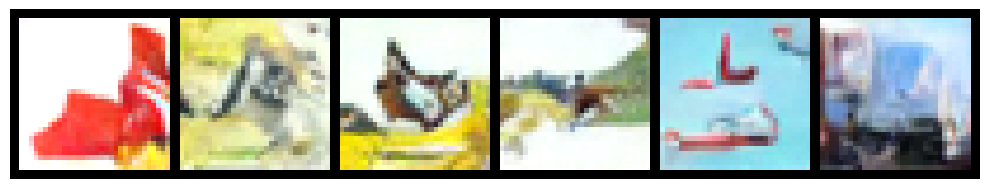

#Imagenes finales Generadas por Exponential Integrator

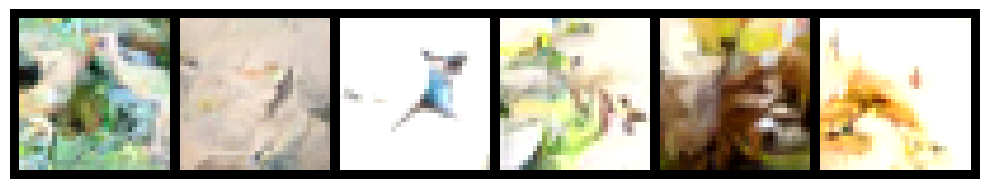

#Imagenes finales Generadas por Probability Flow ODE

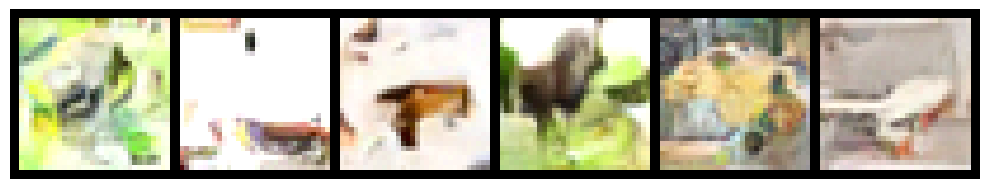

#Imagenes finales Generadas por Euler Maruyama

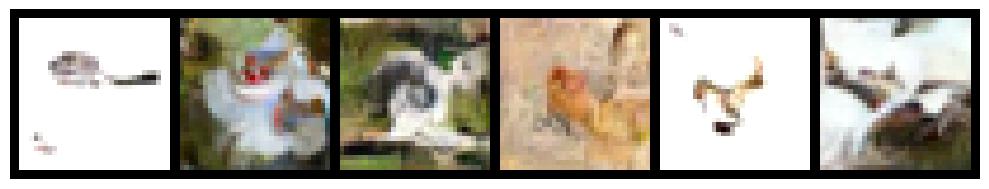

In [ ]:
final_images_plot(final_images)
# len(final_images['Euler Maruyama'])

# Métricas

## BPD

In [ ]:
bdp_cifar(sde_instance, score_model, NUM_WORKERS, IMG_CHANNELS, IMG_SIZE, DEVICE, partition_subset=35) # Partition subset :: Data/partition_subset

Full CIFAR-10 test set size: 10000
Created subset with 285 images (first half of test set).
Image dimensions: C=3, H=32, W=32 => Total=3072

Iniciando cálculo de NLL con compute_nll_scipy...
Calculating NLL using scipy.integrate.solve_ivp (method=RK45). Dequantization enabled.


Calculating NLL:   0%|          | 0/5 [00:00<?, ?it/s]


--- Processing batch 1/5 ---
Data dimensions detected: 3072
Initial batch shape: torch.Size([64, 3, 32, 32])

--- Checking first batch preprocessing ---
Data range check passed: [0.0000, 1.0000] is within expected [0.0, 1.0].
Dequantization check: Values seem plausibly dequantized (mean_residual=2.50e-01).
Data preprocessing check passed successfully.
----------------------------------------
Solving ODE for batch 1...
ODE solved for batch 1. Success: True
Detected VP/SubVP SDE (sigma_t=1.00). Prior variance=1.0.
Batch 1 Avg: log_p_T=-4310.47, delta_log_p=-13855.43, log_p_0=-18165.90, NLL=18165.90

--- Processing batch 2/5 ---
Solving ODE for batch 2...
ODE solved for batch 2. Success: True
Batch 2 Avg: log_p_T=-4302.81, delta_log_p=-13569.80, log_p_0=-17872.61, NLL=17872.61

--- Processing batch 3/5 ---
Solving ODE for batch 3...
ODE solved for batch 3. Success: True
Batch 3 Avg: log_p_T=-4305.05, delta_log_p=-13745.40, log_p_0=-18050.46, NLL=18050.46

--- Processing batch 4/5 ---
Sol

### Bits Per Dimension (BPD): 8.4553

In [ ]:
is_metric(sde_instance, score_model, T, DEVICE, BATCH_SIZE, IS_SPLITS)

Generating images for IS...
Shape of final generated images: torch.Size([200, 3, 32, 32])
Calculating IS on device: cuda
Loading Inception v3 model...
Getting Inception predictions...


Getting Inception Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating Inception Score using 200 images and 10 splits...


### Inception Score calculado:

### Media: 3.2198

### Std Dev: 0.3425

## FID

Generando 100 imágenes sintéticas con VP_Linear para FID...
Generando 100 muestras vía euler_maruyama_integrator (500 steps) en 4 lotes de tamaño 32...


Generando Muestras: 100%|██████████| 4/4 [01:33<00:00, 23.27s/it]


<generate_samples_for_fid> Forma final de salida: torch.Size([100, 3, 32, 32]) usando euler_maruyama_integrator
Imágenes generadas. Tensor shape: torch.Size([100, 3, 32, 32])
Preparando 100 imágenes reales aleatorias de CIFAR-10 para FID...
Dataset CIFAR-10 test cargado. Tamaño total: 10000
Seleccionando 100 imágenes reales al azar de CIFAR-10 test.
 Cargando 100 imágenes reales...


Cargando imágenes reales: 100%|██████████| 100/100 [00:00<00:00, 5791.00it/s]

Imágenes reales preparadas. Tensor shape: torch.Size([100, 3, 32, 32]), Device: cuda:0
Creando DataLoaders para FID...
 Tensor de imágenes generadas movido a cuda.
 Tensor de imágenes reales movido a cuda.
TensorDatasets creados. Tamaño real: 100, Tamaño generado: 100
DataLoaders creados con batch_size=128.

Calculando FID usando 100 imágenes reales y 100 generadas...


Calculando estadísticas de activación para imágenes reales...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 265.31it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando estadísticas de activación para imágenes generadas...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 264.87it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando Distancia de Fréchet (FID)...


### FID Score (VP_Linear): 203.4232


--- Visualizando Algunas Imágenes Generadas (Escaladas a [0, 1] para mostrar) ---


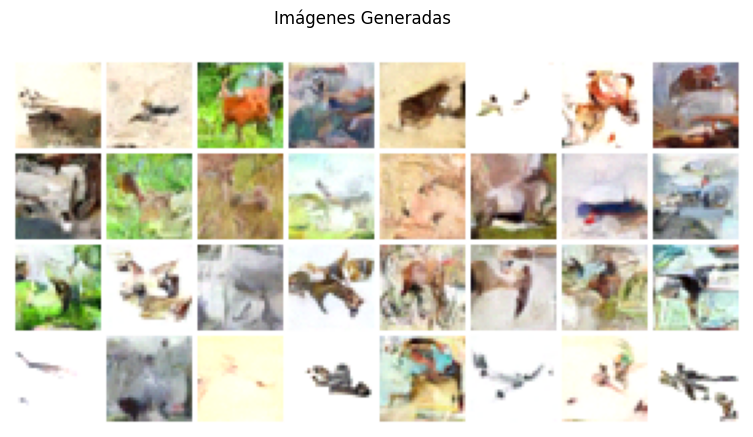

In [ ]:
fid_cifar10(sde_instance, score_model, SAMPLER_FOR_FID, N_FID_SAMPLES, GEN_BATCH_SIZE_FID, IMG_CHANNELS, IMG_SIZE,T, t_final, MODEL_TYPE, SAMPLER_N_STEPS, DEVICE)